In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from scipy import signal
from scipy.interpolate import griddata

import sys
sys.path.append("/home/j/j_mens07/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")
import nanonets_utils
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
%matplotlib inline

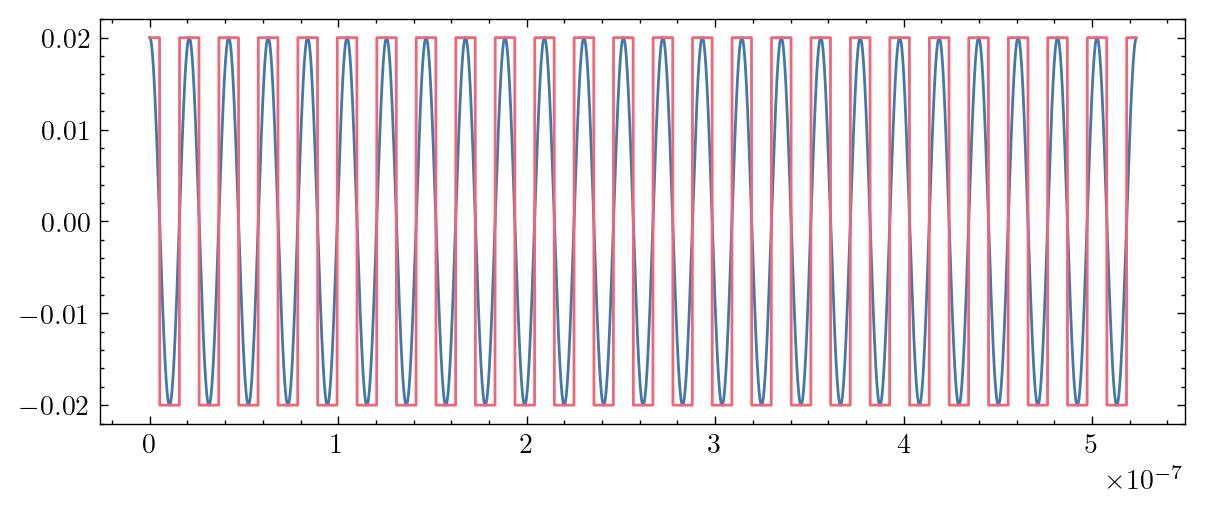

In [2]:
amplitude   = 0.02
freq        = 3.0
time_step   = 1e-10
N_periods   = 50
N_voltages  = int(N_periods*np.pi/(freq*1e8*time_step))
time_steps  = time_step*np.arange(N_voltages)
x_vals      = amplitude*np.cos(freq*time_steps*1e8)
# y_target    = amplitude*signal.sawtooth(freq*time_steps*1e8-np.pi, 0.5)
y_target    = amplitude*signal.square(freq*time_steps*1e8-3*np.pi/2)
x_scaled    = (x_vals-np.mean(x_vals))/np.std(x_vals)
y_scaled    = (y_target-np.mean(y_target))/np.std(y_target)

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot()
    ax.plot(time_steps, x_vals)
    ax.plot(time_steps, y_target)

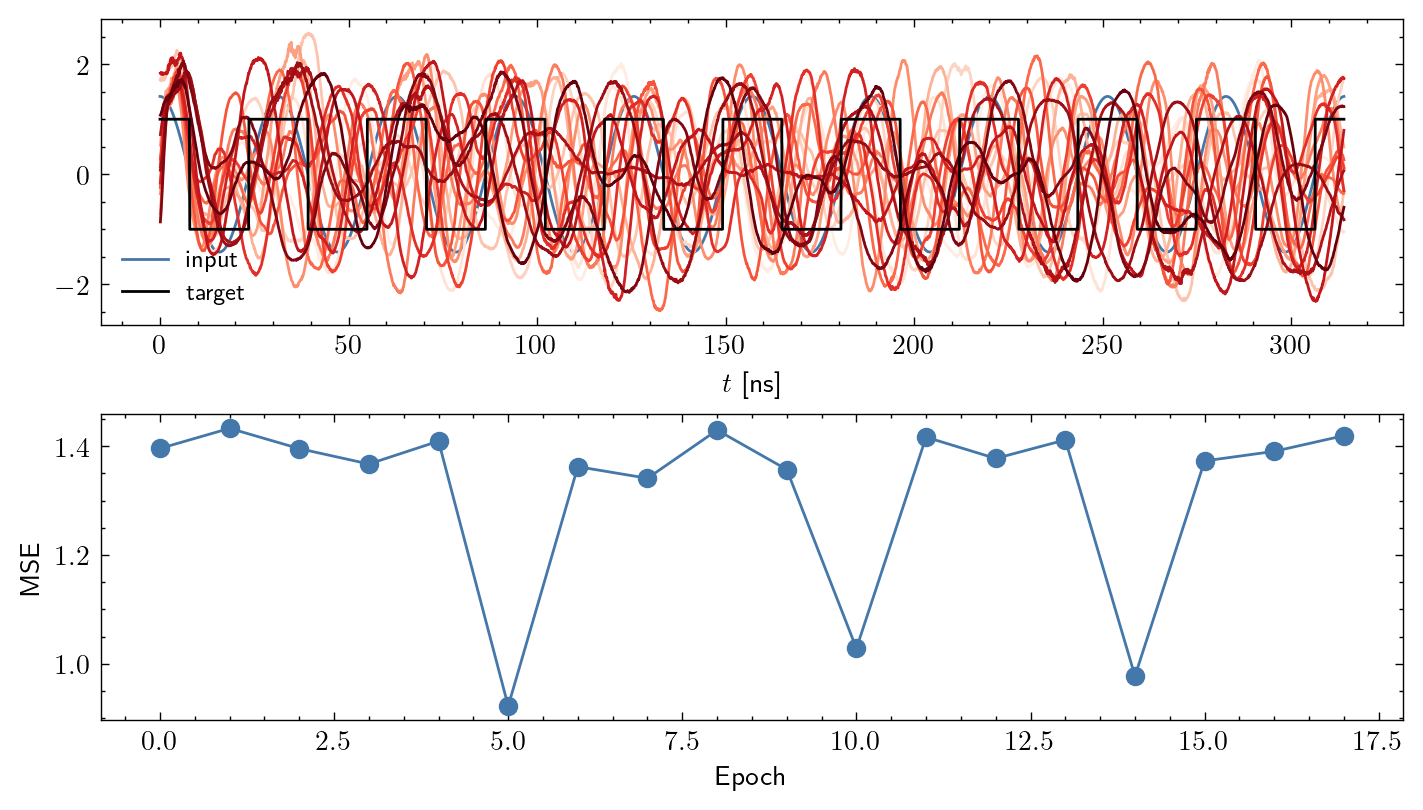

In [59]:
folder  = "../data/sine_to_triangle/"
N_vals  = 18
data    = pd.DataFrame([np.loadtxt(f"{folder}ypred_{i}.csv") for i in range(1,N_vals+1)]).T
data    = data.replace(0, np.nan).dropna(ignore_index=True)
loss    = np.sqrt(np.mean((data.values - y_scaled[1:,np.newaxis])**2, axis=0))
c_map   = plt.get_cmap('Reds')

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    fig.set_figheight(fig.get_figheight()*1.5)
    ax  = fig.add_subplot(2,1,1)
    ax.plot(time_steps*1e9, x_scaled, label="input")
    
    for i, col in enumerate(data.columns):
        ax.plot(time_steps[1:]*1e9, data[col], c=c_map((i+1)/N_vals))

    ax.plot(time_steps*1e9, y_scaled, c='black', label='target')
    ax.set_xlabel("$t$ [ns]")
    ax.legend(fontsize='small', loc='lower left')

    ax  = fig.add_subplot(2,1,2)
    ax.plot(loss, 'o-')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")

In [40]:
results = pd.DataFrame()
errors  = pd.DataFrame()
volts   = []
N_vals  = 1000 #len(y_target)-1

n = 0
for i in range(10):
    for j in range(1):
        df_tmp              = pd.read_csv(f"../data/random_sample_amplitude/Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
        results.loc[:,n]    = df_tmp.iloc[-N_vals:,-2].reset_index(drop=True)
        errors.loc[:,n]     = df_tmp.iloc[-N_vals:,-1].reset_index(drop=True)
        n                   = n + 1

results_norm    = (results-results.mean())/results.std()
results_norm    = results_norm.round(4)
mse             = np.sum((results_norm - y_target[-N_vals:,np.newaxis])**2, axis=0)
min_val         = np.argmin(mse)
results_norm

,0,1,2,3,4,5,6,7,8,9
0,1.1309,1.3840,1.4429,1.3592,1.4092,1.4426,1.3828,1.4391,1.3242,1.0403
1,1.3409,1.4728,1.4292,1.3506,1.3399,1.5241,1.3671,1.4947,1.5215,1.0420
2,1.3324,1.4021,1.4027,1.3745,1.3793,1.4781,1.4567,1.4611,1.4535,1.1146
3,1.3318,1.4471,1.4151,1.3689,1.3886,1.4898,1.4141,1.4315,1.4099,1.1945
4,1.3278,1.4448,1.3631,1.4695,1.3649,1.5255,1.4104,1.4361,1.4793,1.1980
...,...,...,...,...,...,...,...,...,...,...
995,-0.0354,-0.4544,-0.0957,0.1131,0.0735,-0.0809,-0.0453,-0.0114,-0.4765,-0.8793
996,0.1646,-0.4663,-0.0390,0.1763,0.0900,-0.0279,-0.0607,0.0187,-0.3827,-0.7339
997,0.1071,-0.4133,-0.0047,0.1953,0.1156,-0.0066,-0.0030,0.0854,-0.4170,-0.7109
998,0.0724,-0.3032,0.0395,0.2486,0.1836,0.0722,0.0476,0.1154,-0.3700,-0.6902


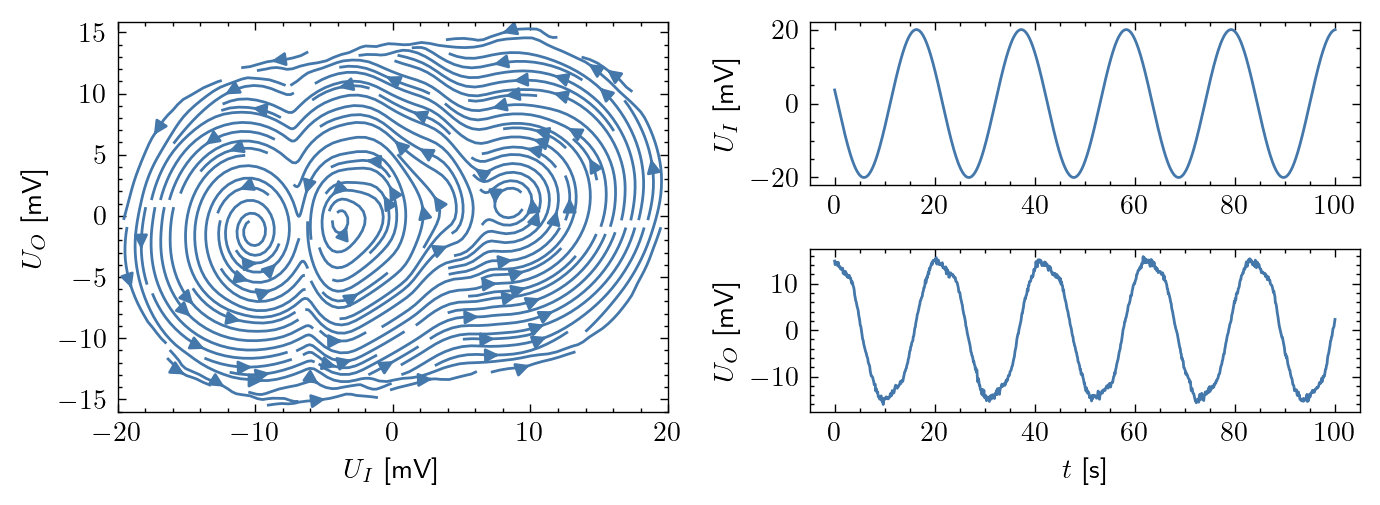

In [68]:
t       = time_steps[:N_vals]
x       = x_vals[-N_vals:]*1000
y       = results[4]*1000
dx_dt   = np.gradient(x, t)
dy_dt   = np.gradient(y, t)
X, Y    = np.meshgrid(np.linspace(np.min(x), np.max(x), 100),
                      np.linspace(np.min(y), np.max(y), 100))
points = np.array([x, y]).T

U = griddata(points, dx_dt, (X, Y), method='linear')
V = griddata(points, dy_dt, (X, Y), method='linear')
U = np.ma.masked_invalid(U)
V = np.ma.masked_invalid(V)

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='tight')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)
    ax.streamplot(X, Y, U, V, density=2)
    ax.set_xlim(-20,20)
    ax.set_xlabel("$U_I$ [mV]")
    ax.set_ylabel("$U_O$ [mV]")

    ax  = fig.add_subplot(2,2,2)
    ax.plot(t*1e9, x)
    ax.set_ylabel("$U_I$ [mV]")

    ax  = fig.add_subplot(2,2,4)
    ax.plot(t*1e9, y)
    ax.set_ylabel("$U_O$ [mV]")
    ax.set_xlabel("$t$ [s]")

ValueError: x and y must have same first dimension, but have shapes (5234,) and (1,)

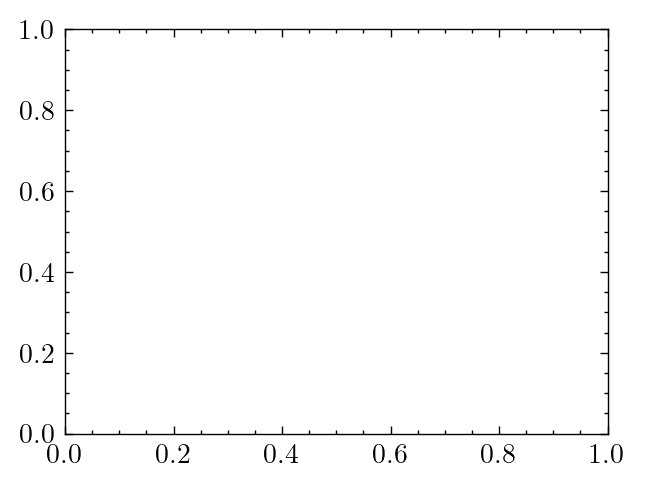

In [28]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax.plot(time_steps[-N_vals:]*1e9, x_vals[min_val])
    ax.plot(time_steps[-N_vals:]*1e9, y_scaled[-N_vals:])

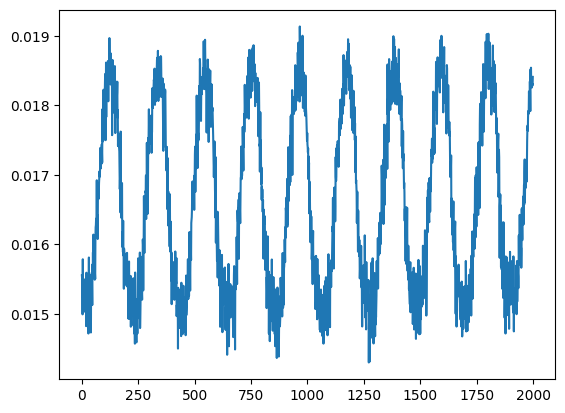

In [52]:
plt.plot(results[min_val])

In [78]:
(results-results.mean())/results.std()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.008237,0.029332,0.035429,0.039813,0.023329,-0.007833,0.082687,0.023971,0.023924,0.046098,...,0.059981,0.001326,0.043447,0.095256,0.049517,0.075966,0.298498,0.056022,0.066273,0.062294
1,0.060508,0.075798,0.085113,0.075211,0.079609,0.040082,0.124028,0.066988,0.067272,0.092189,...,0.104842,0.055536,0.091042,0.139118,0.099809,0.120393,0.339556,0.105053,0.114476,0.105848
2,0.129278,0.136737,0.141603,0.120089,0.148524,0.102080,0.178274,0.119696,0.121993,0.145395,...,0.162987,0.118885,0.160368,0.195378,0.156446,0.178243,0.388523,0.163133,0.173051,0.160523
3,0.207835,0.209765,0.214478,0.165317,0.226291,0.176455,0.240012,0.188869,0.188251,0.203229,...,0.237459,0.194206,0.228921,0.263048,0.225778,0.248555,0.441212,0.234772,0.241080,0.226052
4,0.297385,0.290917,0.291021,0.220325,0.305971,0.255878,0.306704,0.267245,0.272173,0.272564,...,0.317709,0.293799,0.319878,0.331086,0.312222,0.324381,0.507223,0.311065,0.321895,0.303201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,-1.215841,-0.530761,-1.533070,-1.163421,-2.389030,-0.687148,0.699067,0.372469,0.408363,0.110788,...,-1.087157,-1.141877,-1.236473,1.674912,0.240942,1.012103,1.014475,1.139580,-0.193212,-0.043168
3136,-1.239576,-0.508777,-1.541636,-1.174523,-2.340043,-0.734211,0.697568,0.357791,0.410540,0.094541,...,-1.079258,-1.161467,-1.197023,1.668957,0.243530,1.051465,1.028848,1.099153,-0.160775,-0.012350
3137,-1.273155,-0.483388,-1.542302,-1.158626,-2.354538,-0.763691,0.697472,0.341698,0.412895,0.062627,...,-1.062819,-1.210429,-1.173050,1.668389,0.245321,1.103750,1.054345,1.040991,-0.128069,0.006064
3138,-1.313922,-0.468091,-1.550260,-1.166821,-2.344522,-0.819198,0.697859,0.327629,0.401179,0.035919,...,-1.038432,-1.238819,-1.133004,1.642255,0.243657,1.130435,1.052421,0.996904,-0.090398,0.029079


KeyError: 5

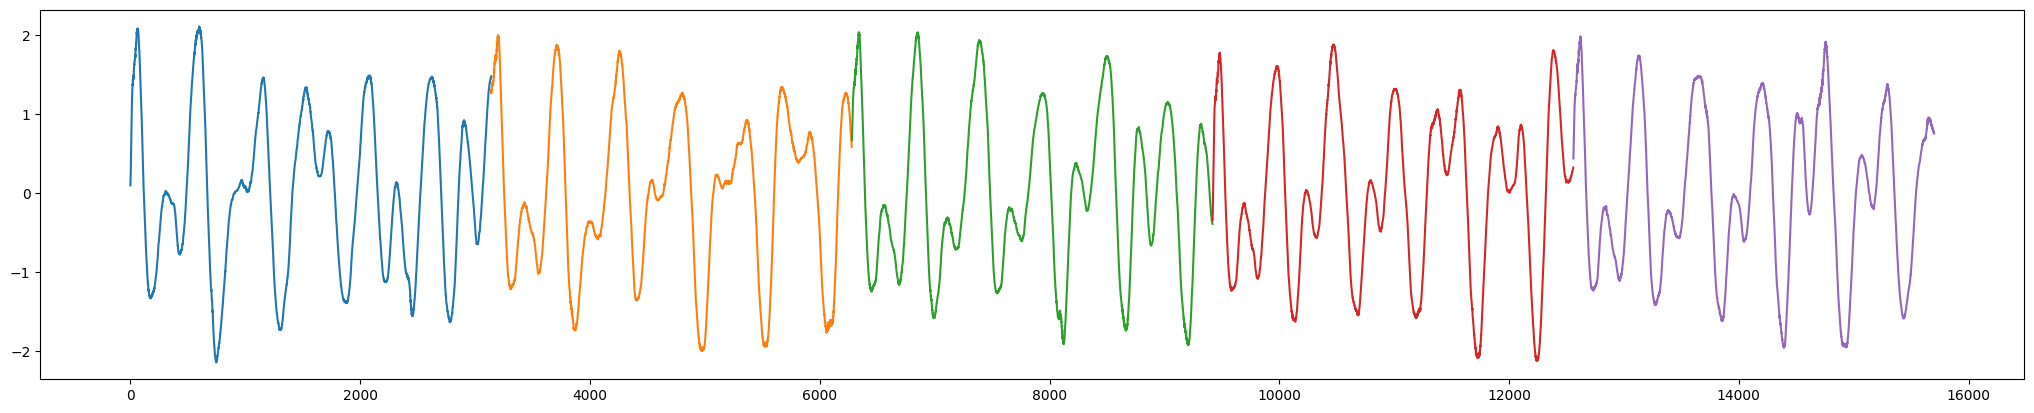

In [34]:
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth()*4)

for i in range(50):
    plt.plot(np.arange(i*len(data[0]), (i+1)*len(data[0])), data[i])

plt.xlim(0,20000)

In [76]:
np.sqrt(np.mean((data.values - y_scaled[1:,np.newaxis])**2, axis=0))

array([0.88466111, 0.7741777 , 0.71208385, 0.65241926, 0.59472555,
       0.55064145])

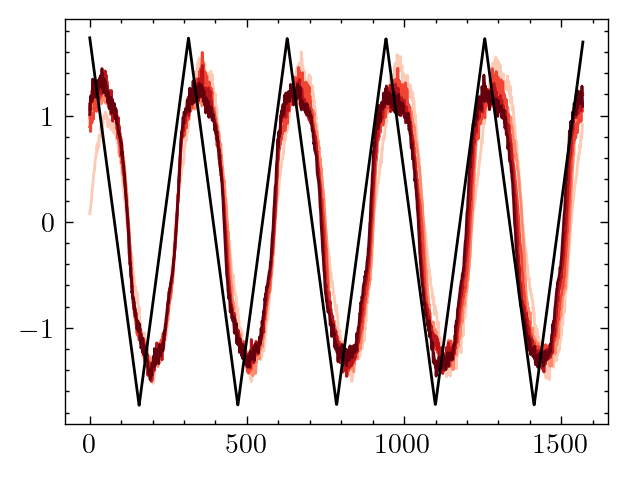

In [48]:
c_map = plt.get_cmap('Reds')

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    for i, col in enumerate(data.columns):
        ax.plot(data[col], c=c_map((i+1)/N_vals))

    ax.plot((y_target-np.mean(y_target))/np.std(y_target), c='black')